# ==========================================
# 1. Imports e Configurações
# ==========================================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Locale para formato brasileiro
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil.1252')
    except:
        pass


# ==========================================
# 2. Leitura do Dataset
# ==========================================

Aqui carrego o dataset já limpo e preparado na etapa anterior de EDA.  
Mostro o shape e as primeiras linhas só para conferir se está tudo certo.

In [ ]:
df = pd.read_csv('export/dataset_preparado_para_modelo.csv')
print(f"Shape do dataset: {df.shape}")
display(df.head())

Shape do dataset: (30000, 31)


,id,limite_credito,sexo,escolaridade,casamento,idade,atraso_0,atraso_2,atraso_3,atraso_4,...,pagto_mes4,pagto_mes5,pagto_mes6,inadimplente,proporcao_pago_1,proporcao_pago_2,proporcao_pago_3,proporcao_pago_4,proporcao_pago_5,proporcao_pago_6
0,1,20000.0,Feminino,Universidade,Casado,24,2,2,-1,-1,...,0.0,0.0,0.0,Sim,0.000000,0.222043,0.000000,0.000000,0.000000,0.000000
1,2,120000.0,Feminino,Universidade,Solteiro,26,-1,2,0,0,...,1000.0,0.0,2000.0,Sim,0.000000,0.579374,0.372717,0.305530,0.000000,0.613121
2,3,90000.0,Feminino,Universidade,Solteiro,34,0,0,0,0,...,1000.0,1000.0,5000.0,Não,0.051915,0.106929,0.073746,0.069774,0.066894,0.321543
3,4,50000.0,Feminino,Universidade,Casado,37,0,0,0,0,...,1100.0,1069.0,1000.0,Não,0.042561,0.041858,0.024345,0.038849,0.036913,0.033843
4,5,50000.0,Masculino,Universidade,Casado,57,-1,0,-1,0,...,9000.0,689.0,679.0,Não,0.232072,6.468171,0.279049,0.429779,0.035985,0.035490


# ==========================================
# 3. Separação em X e y, Treino/Teste
# ==========================================

Aqui, Separo as features (X) e o target (y), removo o ID, e divido em treino e teste mantendo o balanceamento das classes. Isso evita vazamento e garante avaliação justa do modelo.

In [ ]:

X = df.drop(['inadimplente', 'id'], axis=1)
y = df['inadimplente']

# Binário para modelagem
y_bin = (y == "Sim").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.30, random_state=42, stratify=y_bin
)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (21000, 29), Teste: (9000, 29)


# ==========================================
# 4. Identificação de Colunas
# ==========================================

Detecto automaticamente quais colunas são numéricas e quais são categóricas.  
Assim posso aplicar o tratamento adequado para cada tipo no pipeline.

In [ ]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

Numéricas: ['limite_credito', 'idade', 'atraso_0', 'atraso_2', 'atraso_3', 'atraso_4', 'atraso_5', 'atraso_6', 'fatura_mes1', 'fatura_mes2', 'fatura_mes3', 'fatura_mes4', 'fatura_mes5', 'fatura_mes6', 'pagto_mes1', 'pagto_mes2', 'pagto_mes3', 'pagto_mes4', 'pagto_mes5', 'pagto_mes6', 'proporcao_pago_1', 'proporcao_pago_2', 'proporcao_pago_3', 'proporcao_pago_4', 'proporcao_pago_5', 'proporcao_pago_6']
Categóricas: ['sexo', 'escolaridade', 'casamento']


# ==========================================
# 5. Pipeline de Pré-processamento
# ==========================================

## Monto o pipeline:  
- Dados numéricos têm os nulos preenchidos pela média e são padronizados.  
- Dados categóricos têm os nulos preenchidos com o valor mais comum e são convertidos em dummies (OneHotEncoder).  
Deixo tudo pronto para rodar qualquer modelo sem risco de erro de dado faltando.


In [ ]:

from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


# ==========================================
# 6. Modelos para Treinamento
# ==========================================

## Testo vários modelos (Logística, Árvore, Random Forest, XGBoost e LightGBM).  
Para cada um, salvo as principais métricas, matriz de confusão e probabilidades para análise posterior.  
Assim vejo de forma rápida qual modelo performa melhor na base.


In [ ]:
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=120, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

resultados = []

for nome, modelo in modelos.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', modelo)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Matriz de confusão detalhada
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    resultados.append({
        "Modelo": nome,
        "Acurácia (%)": 100*acc,
        "Precisão (%)": 100*prec,
        "Revocação (Recall) (%)": 100*rec,
        "F1-Score (%)": 100*f1,
        "AUC": auc,
        "Verdadeiro Negativo": tn,
        "Falso Positivo": fp,
        "Falso Negativo": fn,
        "Verdadeiro Positivo": tp,
        "y_proba": y_proba,  
        "y_pred": y_pred
    })


[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4800
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,221190 -> initscore=-1,258742
[LightGBM] [Info] Start training from score -1,258742


# ==========================================
# 7. Tabela de Resultados
# ==========================================

Faço um resumo com os principais resultados (acurácia, precisão, recall, F1, AUC e detalhes da matriz de confusão) já formatados para apresentação ou exportação.


In [ ]:
tabela_result = pd.DataFrame(resultados).drop(['y_proba','y_pred'], axis=1)
cols_fmt = [
    "Acurácia (%)", "Precisão (%)", "Revocação (Recall) (%)", "F1-Score (%)",
    "Verdadeiro Negativo", "Falso Positivo", "Falso Negativo", "Verdadeiro Positivo"
]
for col in cols_fmt:
    tabela_result[col] = tabela_result[col].map(lambda x: locale.format_string('%.2f', x, grouping=True) if " (%)" in col else locale.format_string('%d', x, grouping=True))
tabela_result['AUC'] = tabela_result['AUC'].map(lambda x: locale.format_string('%.3f', x) if not pd.isnull(x) else '---')
display(tabela_result)


,Modelo,Acurácia (%),Precisão (%),Revocação (Recall) (%),F1-Score (%),AUC,Verdadeiro Negativo,Falso Positivo,Falso Negativo,Verdadeiro Positivo
0,Regressão Logística,"80,91","69,87","24,11","35,85","0,716",6.802,207,1.511,480
1,Árvore de Decisão,"72,36","38,40","41,34","39,82","0,613",5.689,1.320,1.168,823
2,Random Forest,"81,60","64,86","36,72","46,89","0,755",6.613,396,1.260,731
3,XGBoost,"81,64","64,70","37,47","47,46","0,757",6.602,407,1.245,746
4,LightGBM,"81,83","66,51","36,01","46,73","0,776",6.648,361,1.274,717


# ==========================================
# 8. Visualização das Matrizes de Confusão e Curvas ROC
# ==========================================

Exibo a matriz de confusão e a curva ROC de cada modelo para visualizar onde acertou/errou e como está discriminando entre adimplentes e inadimplentes.

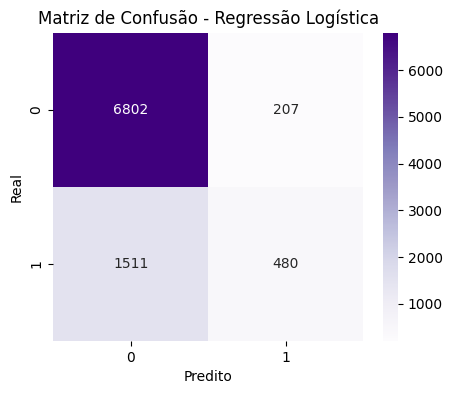

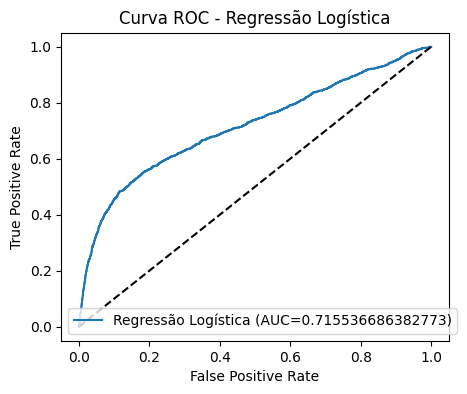

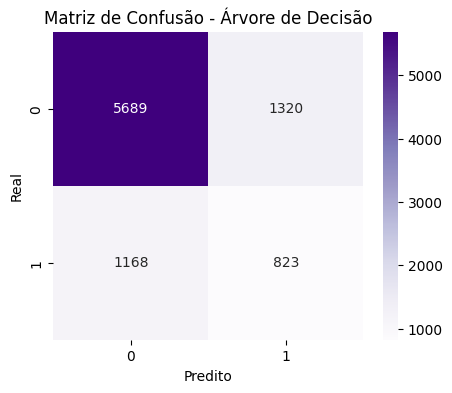

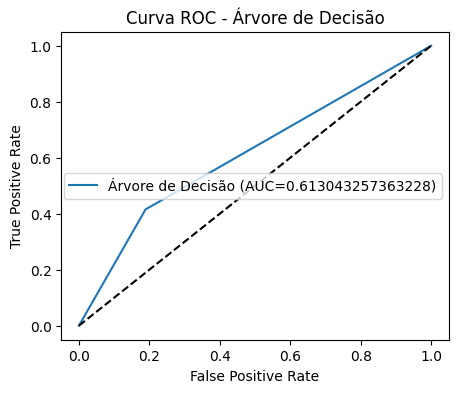

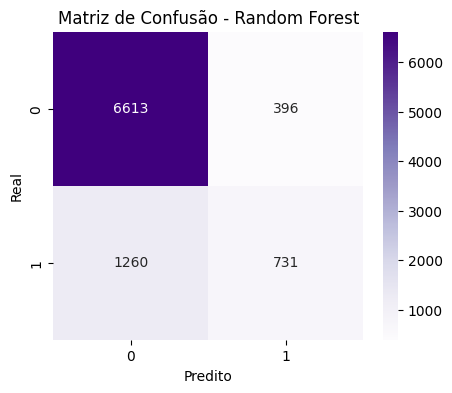

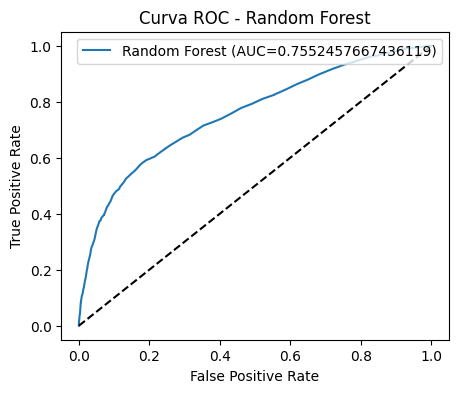

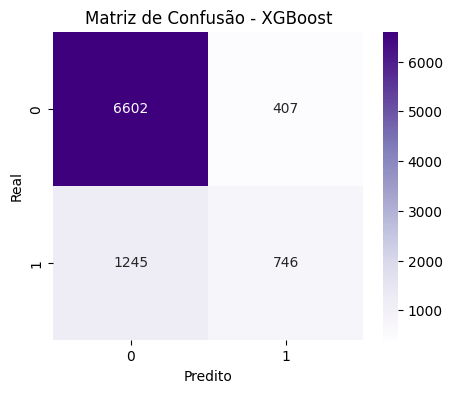

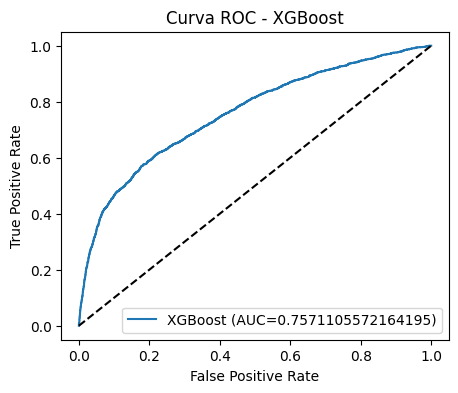

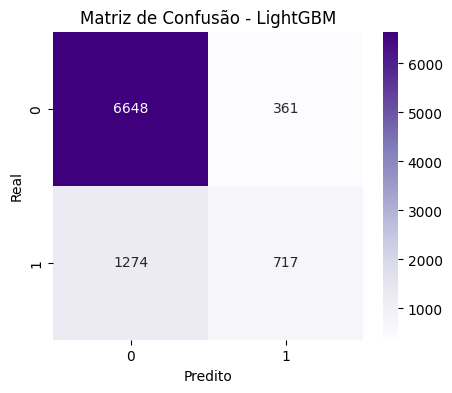

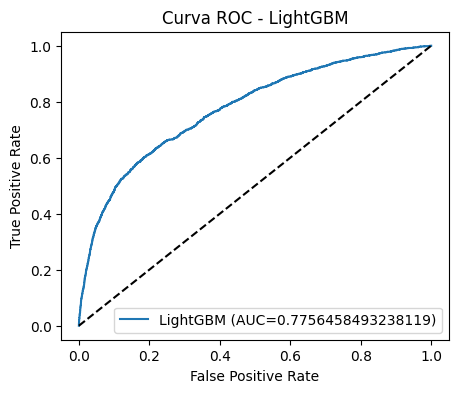

In [ ]:
for i, row in enumerate(resultados):
    nome = row['Modelo']
    cmatrix = np.array([[int(row['Verdadeiro Negativo']), int(row['Falso Positivo'])],
                        [int(row['Falso Negativo']), int(row['Verdadeiro Positivo'])]])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Purples')
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC
    y_proba = resultados[i]['y_proba']
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = resultados[i]['AUC']
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"{nome} (AUC={auc})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nome}")
        plt.legend()
        plt.show()


# ==========================================
# 9. Resumo Executivo dos Resultados dos Modelos
# ==========================================

🔎 **Resumo Executivo**

O modelo com melhor performance para prever inadimplência foi o **LightGBM**.
A métrica AUC (Área sob a Curva ROC), que indica o poder de discriminação entre inadimplentes e não inadimplentes, foi de **0,776** para este modelo.

📊 **Ranking dos Modelos Avaliados:**


,Modelo,Acurácia (%),Precisão (%),Revocação (Recall) (%),F1-Score (%),AUC,Verdadeiro Negativo,Falso Positivo,Falso Negativo,Verdadeiro Positivo
0,Regressão Logística,"80,91","69,87","24,11","35,85","0,716",6.802,207,1.511,480
1,Árvore de Decisão,"72,36","38,40","41,34","39,82","0,613",5.689,1.320,1.168,823
2,Random Forest,"81,60","64,86","36,72","46,89","0,755",6.613,396,1.260,731
3,XGBoost,"81,64","64,70","37,47","47,46","0,757",6.602,407,1.245,746
4,LightGBM,"81,83","66,51","36,01","46,73","0,776",6.648,361,1.274,717



💡 **Interpretação rápida:**
- O LightGBM apresentou o maior AUC, indicando melhor performance para classificação.
- Os modelos de ensemble (Random Forest, XGBoost, LightGBM) superaram os modelos mais simples (Regressão Logística e Árvore de Decisão) neste caso.
- A métrica AUC é a principal referência em problemas de crédito, pois mostra o quão bem o modelo diferencia perfis de risco.


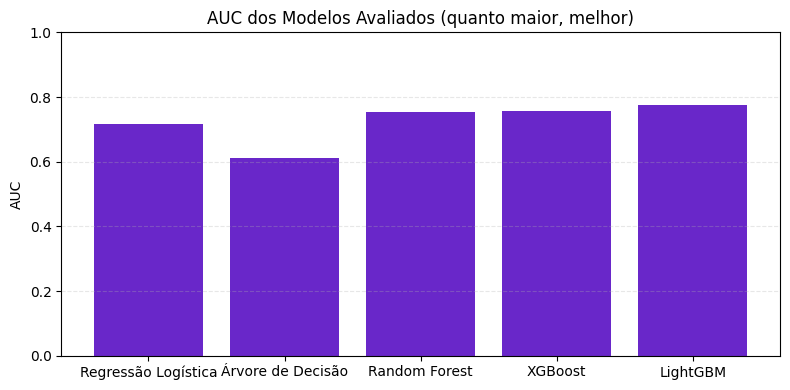

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cria tabela a partir da lista de resultados (se ainda não existir)
tabela_result = pd.DataFrame(resultados).drop(['y_proba','y_pred'], axis=1)

# Formata colunas para português/brasileiro
import locale
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil.1252')
    except:
        pass

cols_fmt = [
    "Acurácia (%)", "Precisão (%)", "Revocação (Recall) (%)", "F1-Score (%)",
    "Verdadeiro Negativo", "Falso Positivo", "Falso Negativo", "Verdadeiro Positivo"
]
for col in cols_fmt:
    tabela_result[col] = tabela_result[col].map(
        lambda x: locale.format_string('%.2f', x, grouping=True) if " (%)" in col else locale.format_string('%d', x, grouping=True)
    )
tabela_result['AUC'] = tabela_result['AUC'].map(
    lambda x: locale.format_string('%.3f', x) if not pd.isnull(x) else '---'
)

# Identifica melhor modelo (maior AUC)
tabela_result['AUC_float'] = pd.to_numeric(tabela_result['AUC'].str.replace(',','.'), errors='coerce')
melhor_idx = tabela_result['AUC_float'].idxmax()
melhor_modelo = tabela_result.loc[melhor_idx, 'Modelo']
melhor_auc = tabela_result.loc[melhor_idx, 'AUC']

print(f"🔎 **Resumo Executivo**")
print(f"\nO modelo com melhor performance para prever inadimplência foi o **{melhor_modelo}**.")
print(f"A métrica AUC (Área sob a Curva ROC), que indica o poder de discriminação entre inadimplentes e não inadimplentes, foi de **{melhor_auc}** para este modelo.\n")

print("📊 **Ranking dos Modelos Avaliados:**")
display(tabela_result.drop(columns='AUC_float').reset_index(drop=True).style
    .highlight_max(subset=['AUC'], color='#c3f7b7')
    .set_caption('Comparação de Modelos - Quanto maior o AUC, melhor o modelo')
)

print("\n💡 **Interpretação rápida:**")
print(f"- O {melhor_modelo} apresentou o maior AUC, indicando melhor performance para classificação.")
print("- Os modelos de ensemble (Random Forest, XGBoost, LightGBM) superaram os modelos mais simples (Regressão Logística e Árvore de Decisão) neste caso.")
print("- A métrica AUC é a principal referência em problemas de crédito, pois mostra o quão bem o modelo diferencia perfis de risco.")

# Ranking visual em barra
plt.figure(figsize=(8,4))
plt.bar(tabela_result['Modelo'], tabela_result['AUC_float'], color="#6927c9")
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.title("AUC dos Modelos Avaliados (quanto maior, melhor)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# ===============================================
# Bloco Final - Salvando Resultados e Melhor Modelo
# ===============================================

In [ ]:
import pandas as pd
import numpy as np
from joblib import dump

# 1. Salva a tabela de resultados dos modelos
df_result = pd.DataFrame(resultados).drop(['y_proba', 'y_pred'], axis=1)
df_result.to_csv('export/modelos_resultados.csv', index=False)
print("✅ Arquivo 'export/modelos_resultados.csv' exportado com sucesso!")

# 2. Salva arrays de predições de TODOS os modelos
for row in resultados:
    nome = row['Modelo']
    pd.DataFrame({
        'y_true': np.array(y_test),  
        'y_pred': np.array(row['y_pred']),
        'y_proba': np.array(row['y_proba']) if row['y_proba'] is not None else [None]*len(y_test)
    }).to_csv(f"export/predicoes_{nome.replace('ç','c').replace('ã','a').replace('á','a').replace('í','i').replace('é','e').replace('ó','o').replace('ú','u').replace('ô','o').replace('ê','e').replace('ô','o').replace(' ','_').replace('-','').replace('__','_').lower()}.csv", index=False)

print("✅ Predições de teste de cada modelo exportadas.")

# 3. Salva o pipeline do melhor modelo (com maior AUC)
df_result['AUC'] = pd.to_numeric(df_result['AUC'], errors='coerce')
melhor_idx = df_result['AUC'].idxmax()
melhor_nome = df_result.loc[melhor_idx, 'Modelo']
print(f"⭐ Melhor modelo encontrado: {melhor_nome}")

melhor_modelo = modelos[melhor_nome]
melhor_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', melhor_modelo)
])
melhor_pipe.fit(X_train, y_train)
dump(melhor_pipe, 'export/melhor_modelo.joblib')
print("✅ Pipeline do melhor modelo salvo em 'export/melhor_modelo.joblib'.")

# 4. Salva dataset de teste com predições do melhor modelo
melhor_pred = melhor_pipe.predict(X_test)
melhor_proba = melhor_pipe.predict_proba(X_test)[:, 1]
df_teste = X_test.copy()
df_teste['inadimplente_real'] = y_test.values
df_teste['inadimplente_pred'] = melhor_pred
df_teste['inadimplente_proba'] = melhor_proba
df_teste.to_csv('export/teste_com_predicoes.csv', index=False)
print("✅ Base de teste com predições salva em 'export/teste_com_predicoes.csv'.")

print("\nTodos os arquivos para o notebook 03 e Power BI foram gerados! 🚀")



✅ Arquivo 'export/modelos_resultados.csv' exportado com sucesso!
✅ Predições de teste de cada modelo exportadas.
⭐ Melhor modelo encontrado: LightGBM
[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4800
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,221190 -> initscore=-1,258742
[LightGBM] [Info] Start training from score -1,258742
✅ Pipeline do melhor modelo salvo em 'export/melhor_modelo.joblib'.
✅ Base de teste com predições salva em 'export/teste_com_predicoes.csv'.

Todos os arquivos para o notebook 03 e Power BI foram gerados! 🚀
